# ***CAR PRICE PREDICTION - NO SUPERVISADO***

# **CPP - RandomForest**

In [1]:
# Detección de Anomalías No Supervisada con RandomForest
# Dataset: Car Price Prediction

# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Cargar el dataset
!git clone https://github.com/suhasmaddali/Car-Prices-Prediction.git

# Cargar CSV
data = pd.read_csv("Car-Prices-Prediction/Data/data.csv")

print("Dimensiones del dataset:", data.shape)
print("Columnas disponibles:", data.columns)
data.head()

In [ ]:
# 3. Revisar dataset
print("Dimensiones del dataset:", data.shape)
print("Columnas:", data.columns.tolist())
print(data.head())

In [4]:
# 4. Separar variable objetivo (MSRP) y variables predictoras
y = data["MSRP"]
X = data.drop("MSRP", axis=1)

In [5]:
# 5. Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=["object"]).columns
numerical_cols = X.select_dtypes(exclude=["object"]).columns

In [ ]:
# 6. One-Hot Encoding para categóricas
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))

# Mantener los nombres de columnas codificadas
X_encoded.columns = encoder.get_feature_names_out(categorical_cols)

# Concatenar variables numéricas + categóricas codificadas
X_final = pd.concat([X[numerical_cols].reset_index(drop=True),
                     X_encoded.reset_index(drop=True)], axis=1)

print("Shape después del encoding:", X_final.shape)

In [ ]:
# 7. Entrenar modelo Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_final, y)

In [8]:
# 8. Calcular error de reconstrucción
predictions = model.predict(X_final)
reconstruction_error = (y - predictions) ** 2

In [ ]:
# 9. Crear DataFrame con resultados
reconstruction_error_df = pd.DataFrame({
    "reconstruction_error": reconstruction_error,
    "index": np.arange(len(y))
})

# Definir umbral (percentil 95)
reconstruction_error_threshold = reconstruction_error_df["reconstruction_error"].quantile(0.95)
reconstruction_error_df["is_anomaly"] = reconstruction_error_df["reconstruction_error"] > reconstruction_error_threshold

print("\nUmbral de anomalía (percentil 95):", reconstruction_error_threshold)

In [ ]:
# 10. Visualización de anomalías
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x="index", y="reconstruction_error", hue="is_anomaly",
    palette={True: "red", False: "skyblue"}, data=reconstruction_error_df, legend=False
)
plt.axhline(y=reconstruction_error_threshold, color="r", linestyle="--", label="Umbral de Anomalía (95%)")
plt.title("Detección de Anomalías en Precios de Autos (MSRP)")
plt.xlabel("Índice del Auto")
plt.ylabel("Puntaje de Anomalía (Error Cuadrático)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# 11. Autos más anómalos
X_original = X.copy()
X_original["MSRP"] = y
X_original["anomaly_score"] = reconstruction_error

print("\n--- Los 10 Autos más Anómalos ---")
print(X_original.sort_values(by="anomaly_score", ascending=False).head(10))

In [12]:
# 1. Métricas de regresión
mae = mean_absolute_error(y, predictions)
r2 = r2_score(y, predictions)

print("Evaluación del Modelo")
print("------------------------------------------------")
print(f"MAE (Error Absoluto Medio): {mae:,.2f}")
print(f"R²: {r2:.4f}")

Evaluación del Modelo
------------------------------------------------
MAE (Error Absoluto Medio): 1,787.90
R²: 0.9892


# **CPP - KNN**

In [13]:
# 1. Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

In [14]:
# Cargar el dataset
!git clone https://github.com/suhasmaddali/Car-Prices-Prediction.git

# Cargar CSV
data = pd.read_csv("Car-Prices-Prediction/Data/data.csv")

print("Dimensiones del dataset:", data.shape)
print("Columnas disponibles:", data.columns)
data.head()

fatal: destination path 'Car-Prices-Prediction' already exists and is not an empty directory.
Dimensiones del dataset: (11914, 16)
Columnas disponibles: Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [15]:
# 3. Preparar variables
# Eliminamos filas con nulos
data = data.dropna()

# Selección de features: quitamos MSRP porque será el objetivo
X = data.drop("MSRP", axis=1)

# Filtramos solo columnas numéricas (KNN no acepta strings)
X = X.select_dtypes(include=[np.number])

# Variable objetivo
y = data["MSRP"]

In [16]:
# ================================
# 4. Escalamiento
# ================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# ================================
# 5. Entrenar modelo KNN
# ================================
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_scaled, y)

KNeighborsRegressor()

In [18]:
# ================================
# 6. Predicciones
# ================================
y_pred = model.predict(X_scaled)

In [19]:
# 7. Evaluación de anomalías
# Error absoluto de predicción
errors = np.abs(y - y_pred)

# Agregamos columna de errores al dataset
data["prediction"] = y_pred
data["error"] = errors

# Definimos umbral como percentil 95 del error
threshold = np.percentile(errors, 95)
data["anomaly"] = data["error"] > threshold

print(f"Umbral de error (95%): {threshold}")
print("Número de anomalías detectadas:", data["anomaly"].sum())

Umbral de error (95%): 15950.159999999963
Número de anomalías detectadas: 405


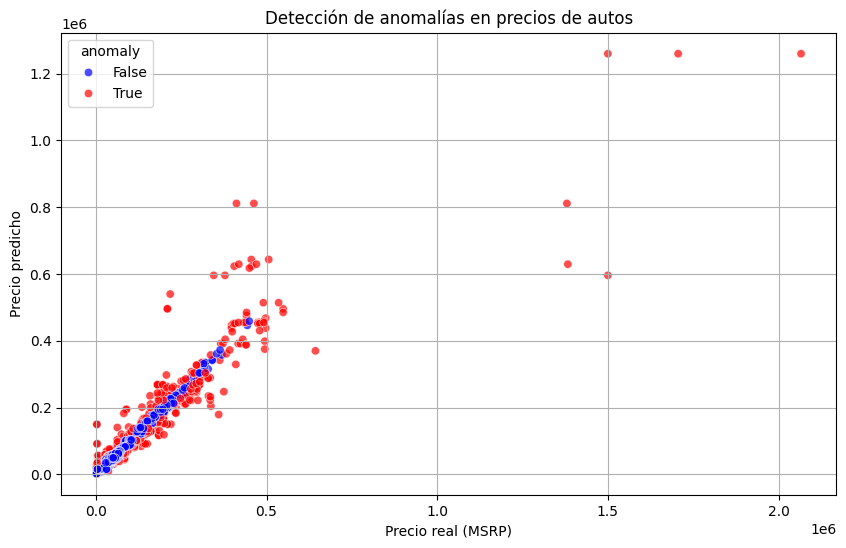

Ejemplos de autos detectados como anomalías:
        Make       Model  Year                Engine Fuel Type  Engine HP  \
46       BMW    2 Series  2016     premium unleaded (required)      320.0   
295  Ferrari         360  2002     premium unleaded (required)      400.0   
300  Ferrari         360  2003     premium unleaded (required)      400.0   
303  Ferrari         360  2004     premium unleaded (required)      425.0   
304  Ferrari         360  2004     premium unleaded (required)      400.0   
452      BMW    4 Series  2017  premium unleaded (recommended)      320.0   
469  Ferrari  458 Italia  2014     premium unleaded (required)      597.0   
471  Ferrari  458 Italia  2015     premium unleaded (required)      562.0   
473  Ferrari  458 Italia  2015     premium unleaded (required)      597.0   
529      BMW    5 Series  2016     premium unleaded (required)      443.0   

     Engine Cylinders Transmission Type     Driven_Wheels  Number of Doors  \
46                6.0        

In [20]:
# 8. Visualización
plt.figure(figsize=(10,6))
sns.scatterplot(x=y, y=y_pred, hue=data["anomaly"], palette={False:"blue", True:"red"}, alpha=0.7)
plt.xlabel("Precio real (MSRP)")
plt.ylabel("Precio predicho")
plt.title("Detección de anomalías en precios de autos")
plt.grid(True)
plt.show()

# Mostrar ejemplos de anomalías
print("Ejemplos de autos detectados como anomalías:")
print(data[data["anomaly"]].head(10))

In [21]:
# 9. Evaluación de desempeño
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("Evaluación del modelo KNN:")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.4f}")


Evaluación del modelo KNN:
MAE  : 5213.08
R²   : 0.8917


# **CPP - Linear Regretion**

In [22]:
# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

In [23]:
# Selección de variable objetivo y features
y = data["MSRP"]

# Eliminamos la variable objetivo y cualquier ID irrelevante
X = data.drop(columns=["MSRP"])

In [24]:
# Preprocesamiento
# Convertir variables categóricas a numéricas con LabelEncoder
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

In [25]:
# Modelo de Regresión Lineal
model = LinearRegression()
model.fit(X_encoded, y)

# Predicciones
predictions = model.predict(X_encoded)

#Evaluación del modelo
mae = mean_absolute_error(y, predictions)
r2 = r2_score(y, predictions)

print("Evaluación del Modelo:")
print(f"MAE (Mean Absolute Error): {mae:,.2f}")
print(f"R² (Coeficiente de Determinación): {r2:.4f}")

Evaluación del Modelo:
MAE (Mean Absolute Error): 5,837.97
R² (Coeficiente de Determinación): 0.9190


In [26]:
# Error de reconstrucción
reconstruction_error = (y - predictions) ** 2

error_df = pd.DataFrame({
    "index": X_encoded.index,
    "reconstruction_error": reconstruction_error,
    "MSRP": y
})

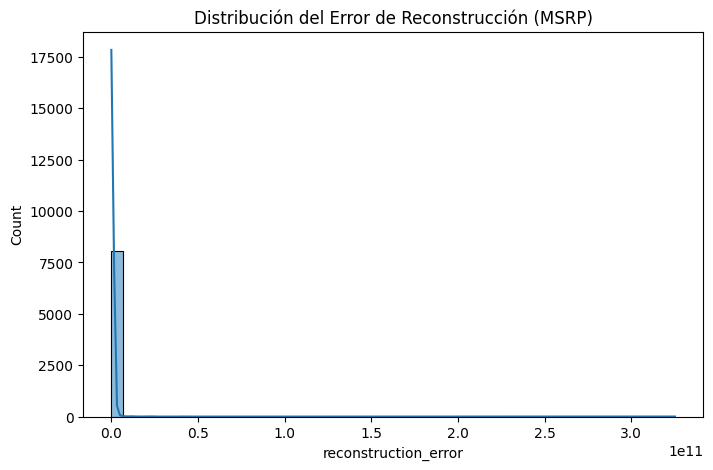

In [27]:
# Visualización de distribución del error
plt.figure(figsize=(8,5))
sns.histplot(error_df["reconstruction_error"], bins=50, kde=True)
plt.title("Distribución del Error de Reconstrucción (MSRP)")
plt.show()

Posibles anomalías (top 10):


,index,reconstruction_error,MSRP
615,615,3.251987e+11,412000
700,700,2.362130e+11,463000
5073,5073,2.209934e+11,217900
2850,2850,1.720028e+11,209600
2851,2851,1.719289e+11,209600
11362,11362,1.562409e+11,2065902
8486,8486,1.399945e+11,1500000
7057,7057,1.247692e+11,345400
6351,6351,1.102895e+11,1382750
7058,7058,8.953151e+10,378200


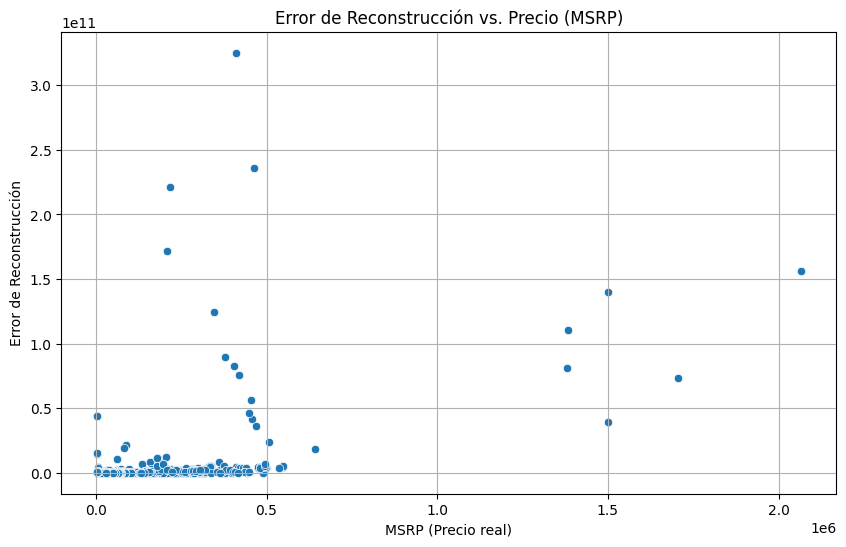

In [28]:
# Identificar posibles anomalías (Top N)
top_anomalias = error_df.sort_values(by="reconstruction_error", ascending=False).head(10)
print("Posibles anomalías (top 10):")
display(top_anomalias)

# Gráfico: MSRP real vs. error
plt.figure(figsize=(10,6))
sns.scatterplot(data=error_df, x="MSRP", y="reconstruction_error")
plt.title("Error de Reconstrucción vs. Precio (MSRP)")
plt.xlabel("MSRP (Precio real)")
plt.ylabel("Error de Reconstrucción")
plt.grid(True)
plt.show()

# **CPP - MLPR**

In [29]:
# ============================
# 1. Importación de librerías
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

In [30]:
# 3. Definir variable objetivo y features
y = data['MSRP']   # variable target
X = data.drop('MSRP', axis=1)

# Eliminamos columnas no numéricas o que no aportan (ajustar según dataset)
X = X.select_dtypes(include=[np.number])

In [31]:
# 4. Escalado de features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
# 5. Definir y entrenar modelo
model = MLPRegressor(hidden_layer_sizes=(100,50),
                     max_iter=1000,
                     random_state=42)

model.fit(X_scaled, y)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

In [33]:
# 6. Predicciones y error de reconstrucción
predictions = model.predict(X_scaled)
reconstruction_error = (y - predictions) ** 2

In [34]:
# 7. Evaluación del modelo
mae = mean_absolute_error(y, predictions)
r2 = r2_score(y, predictions)

print("Evaluación del modelo:")
print(f"MAE  (Error Absoluto Medio): {mae:.2f}")
print(f"R²   (Coeficiente de Determinación): {r2:.4f}")

Evaluación del modelo:
MAE  (Error Absoluto Medio): 4878.91
R²   (Coeficiente de Determinación): 0.9574


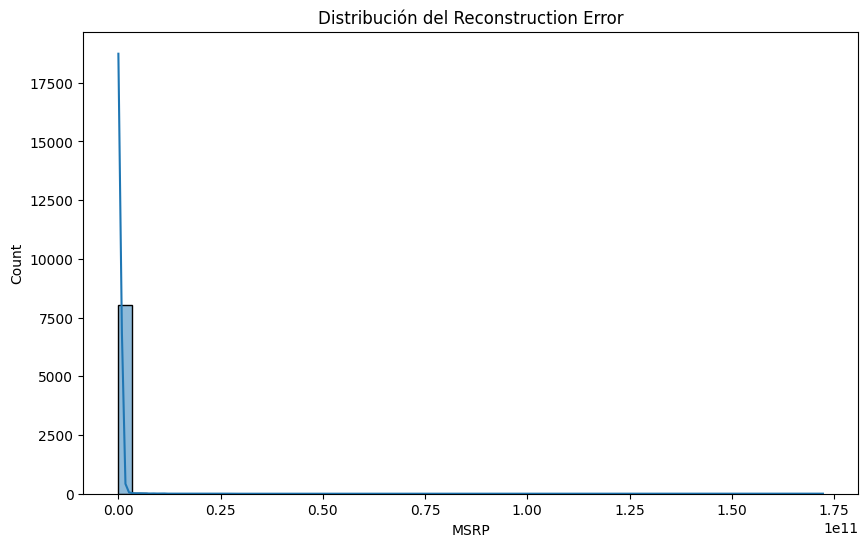

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,...,Vehicle Style,highway MPG,city mpg,Popularity,MSRP,prediction,error,anomaly,Prediction,ReconstructionError
615,Maybach,57,2011,premium unleaded (required),620.0,12.0,AUTOMATIC,rear wheel drive,4.0,"Exotic,Luxury,High-Performance",...,Sedan,16,10,67,412000,811340.0,399340.0,True,8.270935e+05,1.723026e+11
11364,Bugatti,Veyron 16.4,2009,premium unleaded (required),1001.0,16.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",...,Coupe,14,8,820,1705769,1259574.2,446194.8,True,1.330243e+06,1.410197e+11
5073,Mercedes-Benz,G-Class,2016,premium unleaded (required),621.0,12.0,AUTOMATIC,four wheel drive,4.0,"Factory Tuner,Luxury,High-Performance",...,4dr SUV,13,11,617,217900,539910.0,322010.0,True,5.334207e+05,9.955332e+10
6350,Maybach,Landaulet,2011,premium unleaded (required),620.0,12.0,AUTOMATIC,rear wheel drive,4.0,"Exotic,Luxury,High-Performance",...,Convertible,16,10,67,1380000,811340.0,568660.0,True,1.085121e+06,8.695343e+10
700,Maybach,62,2011,premium unleaded (required),620.0,12.0,AUTOMATIC,rear wheel drive,4.0,"Exotic,Luxury,High-Performance",...,Sedan,16,10,67,463000,811340.0,348340.0,True,7.502582e+05,8.251727e+10
7057,Lamborghini,Murcielago,2008,premium unleaded (required),632.0,12.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",...,Coupe,14,9,1158,345400,596000.0,250600.0,True,6.094457e+05,6.972013e+10
11362,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001.0,16.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",...,Coupe,14,8,820,2065902,1259574.2,806327.8,True,1.814872e+06,6.301592e+10
2851,Bentley,Continental Flying Spur Speed,2013,flex-fuel (premium unleaded required/E85),600.0,12.0,AUTOMATIC,all wheel drive,4.0,"Exotic,Flex Fuel,Factory Tuner,Luxury,High-Per...",...,Sedan,17,10,520,209600,495780.0,286180.0,True,4.578907e+05,6.164827e+10
2850,Bentley,Continental Flying Spur Speed,2012,flex-fuel (premium unleaded required/E85),600.0,12.0,AUTOMATIC,all wheel drive,4.0,"Exotic,Flex Fuel,Factory Tuner,Luxury,High-Per...",...,Sedan,17,10,520,209600,495780.0,286180.0,True,4.573533e+05,6.138172e+10
7058,Lamborghini,Murcielago,2008,premium unleaded (required),632.0,12.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",...,Convertible,14,9,1158,378200,596000.0,217800.0,True,5.845305e+05,4.257227e+10


In [36]:
# 8. Análisis de anomalías
data['Prediction'] = predictions
data['ReconstructionError'] = reconstruction_error

plt.figure(figsize=(10,6))
sns.histplot(reconstruction_error, bins=50, kde=True)
plt.title("Distribución del Reconstruction Error")
plt.show()

# Top 10 anomalías
anomalies = data.sort_values(by="ReconstructionError", ascending=False).head(10)
anomalies